In [449]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
# Suppress warnings
warnings.filterwarnings("ignore")

# For reproducibility
np.random.seed(42)

In [439]:
def get_data(tickers, start_date='2014-01-01', end_date='2024-01-01'):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    data = data.dropna()  # Drop rows with any missing values
    return data

def get_crypto_data(tickers, start_date='2014-01-01', end_date='2024-01-01'):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    data = data.fillna(method='ffill').fillna(method='bfill')  # Forward-fill and back-fill missing values
    return data

def preprocess_data(data):
    normalized_data = data / data.iloc[0]
    return normalized_data

In [440]:
def select_pairs(data, top_n=20, method='srmd'):
    n = data.shape[1]
    pairs = list(combinations(range(n), 2))

    if method == 'engle_granger':
        cointegration_results = []
        for (i, j) in pairs:
            stock1 = data.iloc[:, i]
            stock2 = data.iloc[:, j]
            result = engle_granger(stock1, stock2)
            p_value = result.pvalue
            if p_value < 0.05:
                cointegration_results.append((p_value, data.columns[i], data.columns[j], result))
        cointegration_results.sort()
        top_pairs = cointegration_results[:top_n]
        selected_pairs = [(pair[1], pair[2]) for pair in top_pairs]

    elif method == 'srmd':
        distances = []
        for (i, j) in pairs:
            stock1 = data.iloc[:, i]
            stock2 = data.iloc[:, j]
            distance = np.sqrt(np.sum((stock1 - stock2) ** 2))
            distances.append((distance, data.columns[i], data.columns[j]))
        distances.sort()
        top_pairs = distances[:top_n]
        selected_pairs = [(pair[1], pair[2]) for pair in top_pairs]

    return selected_pairs


In [441]:
def calculate_spread(y, x):
    model = sm.OLS(y, sm.add_constant(x)).fit()
    spread = y - model.predict(sm.add_constant(x))
    return spread, model.params

def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return p-value

# def generate_signals(spread, forecasted_spread, mean, std, entry_threshold=2, exit_threshold=0):
#     upper_threshold = mean + entry_threshold * std
#     lower_threshold = mean - entry_threshold * std

#     signals = pd.Series(index=spread.index)

#     signals[forecasted_spread > upper_threshold] = -1
#     signals[forecasted_spread < lower_threshold] = 1
#     signals[abs(spread - mean) < exit_threshold * std] = 0
#     signals.ffill(inplace=True)
#     print("lower_threshold, upper_threshold")
#     print(lower_threshold, upper_threshold)
#     print(forecasted_spread)
#     return signals

In [442]:
def select_arima_model(series, use_SARIMAX=True):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p in range(1, 4):
        for d in range(2):
            for q in range(1, 4):
                try:
                    model = ARIMA(series, order=(p,d,q)).fit()
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p,d,q)
                        best_model = model
                except:
                    continue

    best_seasonal_order = None
    
    if use_SARIMAX:
        for p in range(1, 3):
            for d in range(2):
                for q in range(1, 3):
                    for P in range(0, 2):
                        for D in range(0, 2):
                            for Q in range(0, 2):
                                model = SARIMAX(series, order=(p,d,q), seasonal_order=(P,D,Q,12)).fit(disp=False)
                                if model.aic < best_aic:
                                    best_aic = model.aic
                                    best_order = (p,d,q)
                                    best_seasonal_order = (P,D,Q,12)
                                    best_model = model         
    
    print(best_order)
    print(best_seasonal_order)
    
    model_params = (best_order, best_seasonal_order)
    return best_model, model_params         

In [443]:
def traditional_pairs_trading(today_spread, mean, std, entry_threshold=2, exit_threshold=0):
    global traditional_signal_counter
    
    upper_threshold = mean + entry_threshold * std
    lower_threshold = mean - entry_threshold * std

    signals = pd.Series(index=today_spread.index)

    signals[today_spread > upper_threshold] = 1
    signals[today_spread < lower_threshold] = -1
    signals[abs(today_spread - mean) < exit_threshold * std] = 0
    signals.ffill(inplace=True)
    signals = signals.fillna(0)
    
    traditional_signal_counter += signals[(signals == -1) | (signals == 1)].count()

    return signals

def time_series_pairs_trading(today_spread, forecasted_spread, residuals_std, entry_threshold=0.3, exit_threshold=0):
    global time_series_signal_counter
    signals = pd.Series(index=today_spread.index)
    
    upper_threshold = forecasted_spread + entry_threshold * residuals_std
    lower_threshold = forecasted_spread - entry_threshold * residuals_std
    
    signals[today_spread > upper_threshold] = 1
    signals[today_spread < lower_threshold] = -1
    signals[abs(today_spread - forecasted_spread) < exit_threshold * residuals_std] = 0
    signals.ffill(inplace=True)
    
    time_series_signal_counter += signals[(signals == -1) | (signals == 1)].count()
        
    return signals


In [444]:
def backtest_pairs(data, pairs, entry_threshold=1.5, exit_threshold=0.5, 
                   window_size=252, strategy='time_series', individual_grid_search=False, 
                   orders=None, retrain_steps=10):
    
    results = []
    num_windows = len(data) - window_size - 1
    positions = pd.DataFrame(index=data.index)

    if strategy == 'time_series':
        if orders is not None:
            arima_params = dict()
            for idx, (stock1, stock2) in enumerate(pairs):
                arima_params[(stock1, stock2)] = orders[idx]
        elif not individual_grid_search:
            arima_params = dict()
            for stock1, stock2 in pairs:
                spread, params = calculate_spread(data[stock1], data[stock2])
                _, model_params = select_arima_model(spread, use_SARIMAX=True)
                arima_params[(stock1, stock2)] = model_params
    
        print(arima_params)
        
    cached_models=dict()
    for start in tqdm(range(num_windows)):
        train_start = start
        train_end = train_start + window_size

        train_data = data.iloc[train_start:train_end]
        test_data = data.iloc[[train_end]]
        test_data_return = data.iloc[train_end-1:train_end+1].pct_change().iloc[[-1]]
        
        pair_returns = []
        
        for stock1, stock2 in pairs:
            pair_name = "_".join([stock1, stock2])
            
#             print(train_data[stock1])
#             print(train_data[stock2])
            spread, params = calculate_spread(train_data[stock1], train_data[stock2])
#             print(spread)
#             print(params)
            alpha = params[0]
            beta = params[1]

            # Check stationarity of the spread
            if adf_test(spread) >= 0.05:
                spread = spread.diff().dropna()

            mean = spread.mean()
            std = spread.std()
            today_spread = test_data[stock1] - (alpha + beta * test_data[stock2])

            if strategy == 'time_series':
                #only refresh model every retrain_step windows
                if retrain_steps is None or start % retrain_steps == 0: 
                    if individual_grid_search:
                        model, _ = select_arima_model(spread, False)
                    else:
                        model_params = arima_params[(stock1, stock2)]
                        if model_params[1] is None:
                            model = ARIMA(spread, order=model_params[0]).fit()
                        else:
                            model = SARIMAX(spread, order=model_params[0], 
                                            seasonal_order=model_params[1]).fit(disp=False)
                    cached_models[pair_name] = model
                else:
                    model = cached_models[pair_name]
                
                train_forecast = model.predict(start=0, end=len(spread)-1, dynamic=False)
                residuals = spread - train_forecast
                residuals_std = residuals.std()
                
                today_forecast = train_forecast[-1]

                signals = time_series_pairs_trading(today_spread, today_forecast, residuals_std, entry_threshold)
                positions.loc[test_data.index[-1], pair_name] = signals.iloc[-1]

            else:  # Traditional strategy
                signals = traditional_pairs_trading(today_spread, mean, std, entry_threshold, exit_threshold)
                positions.loc[test_data.index[-1], pair_name] = signals.iloc[-1]

            # Calculate Daily Returns
            stock1_return = test_data_return[stock1].values[0]
            stock2_return = test_data_return[stock2].values[0]
            spread_return = stock1_return - beta * stock2_return
            position_signal = positions.loc[test_data.index[-1], pair_name]
            
#             print(f"Stock1 Return: {stock1_return}, Beta: {beta}, Stock2 Return: {stock2_return}")
#             print(f"Spread Return: {spread_return}, Position Signal: {position_signal}")
#             print(f"today_spread: {today_spread[0]}, mean: {mean}, std:{std}")
            
            daily_return = spread_return * position_signal
            pair_returns.append(pd.Series(daily_return, index=test_data.index[-1:]))

        # Calculate Weights after all pairs have been processed
        weights = positions.abs().sum(axis=1).replace(0, np.nan).loc[test_data.index[-1]]

        # Calculate Weighted Returns for each pair
        weighted_returns = [daily_return / weights if weights != 0 else daily_return for daily_return in pair_returns]

        # Store Pair Returns
        results.append(pd.concat(weighted_returns, axis=1).mean(axis=1))
    
    
#     return results, positions
    # Aggregate Pair Returns and Calculate Cumulative Returns
    results_df = pd.concat(results)
    results_df['cumulative'] = (1 + results_df.fillna(0)).cumprod() - 1

#     print(results_df)
    return results_df, positions
    
#     results_df = pd.concat(traditional_returns)
#     results_df['cumulative'] = (1 + results_df.fillna(0)).cumprod() - 1
#     return results_df, positions
#             weights = positions.abs().sum(axis=1).replace(0, np.nan)
            
#             stock1_return = test_data_return[stock1]
#             stock2_return = test_data_return[stock2]
#             spread_return = stock1_return - beta * stock2_return

#             daily_return = spread_return * positions.loc[test_data.index[-1], "_".join([stock1, stock2])]
#             weighted_returns = daily_returns / weights
            
#             # Store Pair Returns
#             pair_returns.loc[test_data.index[-1]] = daily_return
        
        
#         # Aggregate and normalize the pair returns
#         daily_weighted_return = pair_returns.div(weights.loc[test_data.index[-1]])
#         results.append(daily_weighted_return)
    
#     return results, positions

In [447]:
sp500_tickers = ["WEC", "XEL", "EQR", "ESS", "CCL", "NCLH", "CMS", "ETR", "AVB", "UDR"] # Example tickers, replace with full S&P 500 tickers list
data = get_data(sp500_tickers, start_date='2020-01-01', end_date='2023-01-01')
normalized_data = preprocess_data(data)

[*********************100%%**********************]  10 of 10 completed


In [448]:
selected_pairs = select_pairs(normalized_data, top_n=5)
print(f"Selected pairs: {selected_pairs}")


Selected pairs: [('CMS', 'WEC'), ('CCL', 'NCLH'), ('EQR', 'ESS'), ('AVB', 'EQR'), ('WEC', 'XEL')]


In [408]:
global traditional_signal_counter
global time_series_signal_counter
traditional_signal_counter = 0
time_series_signal_counter = 0

traditional_returns, traditional_positions = backtest_pairs(normalized_data, selected_pairs, strategy='traditional')
print(traditional_signal_counter)


100%|██████████| 503/503 [00:29<00:00, 16.85it/s]

1643


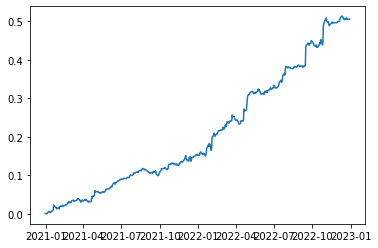

In [417]:
plt.plot(traditional_returns['cumulative'])

In [410]:
global time_series_signal_counter
time_series_signal_counter = 0


orders = [((3, 1, 3), None),
          ((2, 1, 2),(0, 1, 1, 12)), 
          ((2, 1, 2),(0, 1, 1, 12)),
          ((2, 1, 2),(1, 1, 1, 12)), 
          ((2, 1, 2), (0, 1, 1, 12))]

ts_returns, ts_positions = backtest_pairs(data, selected_pairs, 
                                          strategy='time_series', individual_grid_search=False, 
                                          orders=orders, retrain_steps=None)

  0%|          | 0/503 [00:00<?, ?it/s]

{('GOOGL', 'MSFT'): ((3, 1, 3), None), ('ADBE', 'AMZN'): ((2, 1, 2), (0, 1, 1, 12)), ('ADBE', 'META'): ((2, 1, 2), (0, 1, 1, 12)), ('META', 'NFLX'): ((2, 1, 2), (1, 1, 1, 12)), ('ADBE', 'NFLX'): ((2, 1, 2), (0, 1, 1, 12))}


100%|██████████| 503/503 [39:45<00:00,  4.74s/it]


In [414]:
ts_returns['cumulative']

Date
2020-12-31    0.003530
2021-01-04   -0.004668
2021-01-05    0.003042
2021-01-06    0.001784
2021-01-07    0.022151
                ...   
2022-12-22    1.132724
2022-12-23    1.122838
2022-12-27    1.132548
2022-12-28    1.138227
2022-12-29    1.122891
Length: 503, dtype: float64

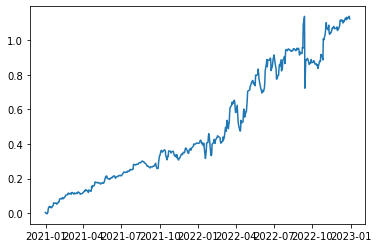

In [416]:
plt.plot(ts_returns['cumulative'])

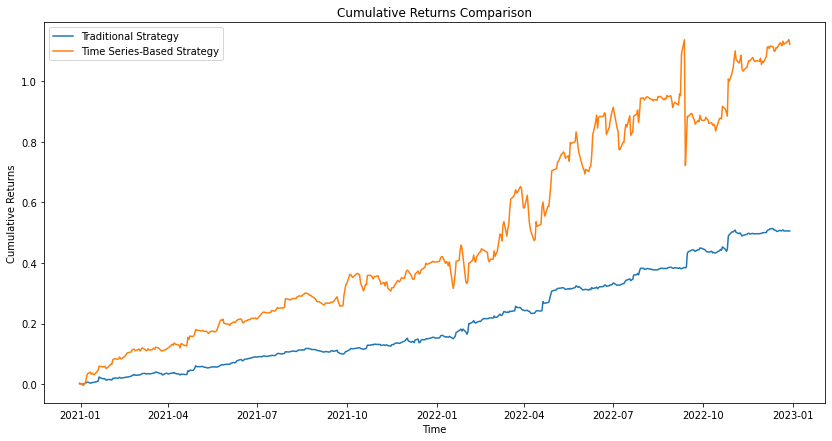

In [418]:
plt.figure(figsize=(14, 7))
plt.plot(traditional_returns['cumulative'], label='Traditional Strategy')
plt.plot(ts_returns['cumulative'], label='Time Series-Based Strategy')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [ ]:
def plot_acf_pacf(series, lags=30):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    plt.show()

def plot_arima_predictions(data, model_fit, forecast_steps=10):
    forecast = model_fit.forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, inclusive='right')[1:]
    forecast_series = pd.Series(forecast, index=forecast_index)

    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Original Data')
    plt.plot(model_fit.fittedvalues, color='red', label='Fitted Values')
    plt.plot(forecast_series, color='green', linestyle='dashed', label='Forecast')
    plt.title('ARIMA Model Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
def analyze_spread_residuals(spread, residuals):
    plt.figure(figsize=(14, 7))
    plt.subplot(211)
    plt.plot(spread, label='Spread')
    plt.title('Spread and Residuals')
    plt.legend()

    plt.subplot(212)
    plt.plot(residuals, label='Residuals')
    plt.legend()
    plt.show()

    plot_acf_pacf(spread, lags=30)
    plot_acf_pacf(residuals, lags=30)

def plot_cumulative_returns(traditional_returns, ts_returns):
    cumulative_returns_traditional = (1 + traditional_returns['total'].fillna(0)).cumprod() - 1
    cumulative_returns_ts = (1 + ts_returns['total'].fillna(0)).cumprod() - 1

    plt.figure(figsize=(14, 7))
    plt.plot(cumulative_returns_traditional, label='Traditional Strategy')
    plt.plot(cumulative_returns_ts, label='Time Series-Based Strategy')
    plt.title('Cumulative Returns Comparison')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

## Crypto ##

In [323]:
crypto_tickers = ["BTC-USD", "ETH-USD", "LTC-USD", "XRP-USD", "BCH-USD", "ADA-USD", 
                  "LINK-USD", "BNB-USD", "XLM-USD", "DOGE-USD", "EOS-USD", 
                  "TRX-USD"]

crypto_data = get_data(crypto_tickers, start_date='2017-11-09', end_date='2024-01-01')
normalized_crypto_data = preprocess_data(crypto_data)


[*********************100%%**********************]  12 of 12 completed


In [324]:
normalized_crypto_data

Ticker,ADA-USD,BCH-USD,BNB-USD,BTC-USD,DOGE-USD,EOS-USD,ETH-USD,LINK-USD,LTC-USD,TRX-USD,XLM-USD,XRP-USD
Date,,,,,,,,,,,,
2017-11-09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2017-11-10,0.846067,1.539684,0.902585,0.926446,0.821908,0.872840,0.932589,0.837625,0.922054,0.858788,0.827943,0.949400
2017-11-11,0.855988,2.048669,0.839107,0.889974,0.848763,0.986602,0.980669,0.802656,0.969404,0.854522,0.827442,0.967548
2017-11-12,0.748042,2.122656,0.763368,0.832925,0.733569,0.926465,0.959562,0.763043,0.918091,0.760666,0.705502,0.907356
2017-11-13,0.805166,2.069362,0.847220,0.918236,0.855830,0.998374,0.987011,0.817394,0.955295,0.901024,0.767436,0.935417
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,19.765233,0.403616,162.589019,6.081384,66.133573,0.766279,7.413084,74.439202,1.180188,44.969710,3.275747,2.919039
2023-12-28,19.262533,0.401185,162.549668,5.967296,64.935693,0.737674,7.315934,71.667653,1.193756,45.051196,3.313523,2.919692
2023-12-29,18.983994,0.388983,157.667011,5.893320,64.337814,0.718948,7.169852,69.357483,1.142127,45.089164,3.244856,2.866374


In [325]:
selected_crypto_pairs = select_pairs(normalized_crypto_data, top_n=5)
print(f"Selected pairs: {selected_crypto_pairs}")

Selected pairs: [('BCH-USD', 'LTC-USD'), ('LTC-USD', 'XRP-USD'), ('BTC-USD', 'ETH-USD'), ('BTC-USD', 'XRP-USD'), ('BCH-USD', 'XRP-USD')]


In [326]:
global traditional_signal_counter
global time_series_signal_counter
traditional_signal_counter = 0
time_series_signal_counter = 0

traditional_returns, traditional_positions = backtest_pairs(normalized_crypto_data, selected_crypto_pairs, strategy='traditional')
print(traditional_signal_counter)


100%|██████████| 1991/1991 [01:53<00:00, 17.57it/s]

6662


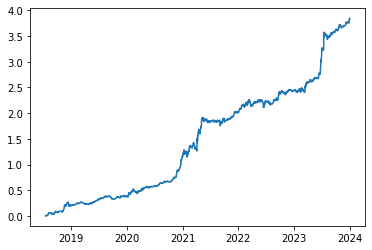

In [308]:
plt.plot(traditional_returns['cumulative'])

In [255]:
def save_backtest_results_to_csv(results_df, filename="backtest_results.csv"):
    # Ensure the DataFrame contains the necessary columns
    if 'cumulative' in results_df.columns:
        results_df = results_df.drop(columns=['cumulative'])
    
    # Rename the columns for clarity
    results_df.columns = ['daily_return']
    
    # Save to CSV file
    results_df.to_csv(filename, index_label='date')

In [329]:
print(traditional_returns)
print(type(traditional_returns[0]))
# save_backtest_results_to_csv(traditional_returns, "crypto_common_pairs_trading.csv")

def save_series_list_to_csv(data, filename="backtest_results.csv"):
    # Combine the list of Series into a single DataFrame
    results_df = pd.concat(data, axis=0)
    
    # Ensure the DataFrame contains the necessary columns
    results_df.columns = ['daily_return']
    
    # Save to CSV file
    results_df.to_csv(filename, index_label='date')
    
save_series_list_to_csv(traditional_returns, filename="crypto_pairs_trading.csv")

[Date
2018-07-19    0.000213
dtype: float64, Date
2018-07-20    0.010855
dtype: float64, Date
2018-07-21   -0.004764
dtype: float64, Date
2018-07-22   -0.000454
dtype: float64, Date
2018-07-23    0.000638
dtype: float64, Date
2018-07-24   NaN
dtype: float64, Date
2018-07-25   NaN
dtype: float64, Date
2018-07-26   NaN
dtype: float64, Date
2018-07-27   NaN
dtype: float64, Date
2018-07-28   NaN
dtype: float64, Date
2018-07-29   NaN
dtype: float64, Date
2018-07-30   NaN
dtype: float64, Date
2018-07-31   NaN
dtype: float64, Date
2018-08-01    0.003278
dtype: float64, Date
2018-08-02    0.007158
dtype: float64, Date
2018-08-03    0.004006
dtype: float64, Date
2018-08-04    0.008151
dtype: float64, Date
2018-08-05   -0.003205
dtype: float64, Date
2018-08-06    0.000879
dtype: float64, Date
2018-08-07    0.008263
dtype: float64, Date
2018-08-08    0.015272
dtype: float64, Date
2018-08-09   -0.006153
dtype: float64, Date
2018-08-10    0.008267
dtype: float64, Date
2018-08-11   -0.001426
dtype: 

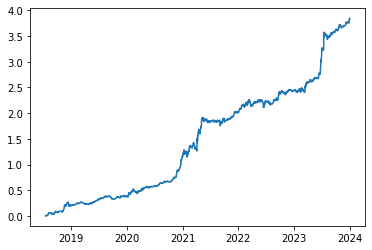

In [330]:
results_df = pd.concat(traditional_returns)
results_df['cumulative'] = (1 + results_df.fillna(0)).cumprod() - 1
plt.plot(results_df['cumulative'])

In [474]:
def calculate_cumulative_return(returns):
    return (1 + returns).cumprod() - 1

# def calculate_sharpe_ratio(returns, risk_free_rate=0):
#     excess_returns = returns - risk_free_rate
#     return np.mean(excess_returns) / np.std(excess_returns)

def calculate_sharpe_ratio(returns, risk_free_rate=0):
    mean_daily_return = returns.mean()
    std_daily_return = returns.std()
    
    annualized_return = (1 + mean_daily_return) ** 252 - 1
    annualized_volatility = std_daily_return * np.sqrt(252)
    
    return (annualized_return - risk_free_rate) / annualized_volatility

def calculate_max_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    return drawdown.min()

In [480]:
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


def backtest_pair(data, pair, entry_threshold=1.5, exit_threshold=0.5,
                  window_size=252, strategy='time_series', individual_grid_search=False, order=None):

    results = pd.Series(index=data.index) #[]
    num_windows = len(data) - window_size - 1
    positions = []#pd.Series(index=data.index)

    stock1, stock2 = pair

#     if strategy == 'time_series':
#         if order is None and not individual_grid_search:
#             spread, params = calculate_spread(data[stock1], data[stock2])
#             _, model_params = select_arima_model(spread, use_SARIMAX=True)
#         elif order is not None:
#             model_params = order
    
    cached_model=None
    retrain_steps = None
    for start in tqdm(range(num_windows)):
        train_start = start
        train_end = train_start + window_size

        train_data = data.iloc[train_start:train_end]
        test_data = data.iloc[[train_end]]
        test_data_return = data.iloc[train_end-1:train_end+1].pct_change().iloc[[-1]]

        spread, params = calculate_spread(train_data[stock1], train_data[stock2])
        alpha = params[0]
        beta = params[1]

        # Check stationarity of the spread
        if adf_test(spread) >= 0.05:
            spread = spread.diff().dropna()

        mean = spread.mean()
        std = spread.std()
        today_spread = test_data[stock1] - (alpha + beta * test_data[stock2])

        if strategy == 'time_series':
            model = ARIMA(spread, order=(1, 0, 5)).fit()
            train_forecast = model.predict(start=0, end=len(spread) - 1) 
#             train_forecast = model.predict(start=0, end=len(spread) - 1) 
#             if retrain_steps is None or start % retrain_steps == 0: 
#                 if individual_grid_search:
#                     model, _ = select_arima_model(spread, False)
#                 else:
#                     if model_params[1] is None:
#                         model = ARIMA(spread, order=model_params[0]).fit()
#                     else:
#                         model = SARIMAX(spread, order=model_params[0], seasonal_order=model_params[1]).fit(disp=False)

#                 cached_model = model
#                 train_forecast = model.predict(start=0, end=len(spread)-1, dynamic=False)[-1]
#             else:
#                 model = cached_model
#                 model = model.append([spread[-1]], refit=False)
#                 cached_model = model
#                 train_forecast = model.forecast(steps=1).iloc[0]
            
            
            residuals = spread - train_forecast
            residuals_std = residuals.std()

            today_forecast = train_forecast[-1]

            signals = time_series_pairs_trading(today_spread, today_forecast, residuals_std, entry_threshold)
            
#             print(signals)
#             print(pd.isna(signals)[-1])
#             print(pd.isna(signals.iloc[-1]))
            if pd.isna(signals)[-1]:
                positions.append(positions[-1] if len(positions)>0 else 0)
            else:
                positions.append(signals.iloc[-1])
            
        else:  # Traditional strategy
            signals = traditional_pairs_trading(today_spread, mean, std, entry_threshold, exit_threshold)
            positions.append(signals.iloc[-1])

        # Calculate Daily Returns
        stock1_return = test_data_return[stock1].values[0]
        stock2_return = test_data_return[stock2].values[0]
        spread_return = stock1_return - beta * stock2_return
        position_signal = positions[-1]

        daily_return = spread_return * position_signal
        results[test_data.index[-1]] = daily_return

    cumulative_returns = calculate_cumulative_return(results)
    sharpe_ratio = calculate_sharpe_ratio(results)
    max_drawdown = calculate_max_drawdown(cumulative_returns)

    return results, positions, cumulative_returns, sharpe_ratio, max_drawdown

sp500_tickers = ["WEC", "XEL", "EQR", "ESS", "CCL", "NCLH", "CMS", "ETR", "AVB", "UDR"] 
data = get_data(sp500_tickers, start_date='2018-01-01', end_date='2023-01-01')
normalized_data = preprocess_data(data)

# ARMA(1,5) ARMA(3,3) ARIMA(0,1,5) ARMA(1,7) ARIMA(0,1,5)



## Traditional Pairs Trading


# pair = ('WEC', 'XEL')
# pair = ("EQR", "ESS")
# pair = ("CCL", "NCLH")
pair = ("CMS", "ETR")
# pair = ("AVB", "UDR")

x = backtest_pair(normalized_data, pair, strategy='traditional')
print(x)

# x = backtest_pair(normalized_data, pair, strategy='time_series')
# print(x)

[*********************100%%**********************]  10 of 10 completed
100%|██████████| 1006/1006 [00:11<00:00, 85.59it/s]

(Date
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-08         NaN
                ...   
2022-12-23   -0.010546
2022-12-27    0.000008
2022-12-28   -0.003996
2022-12-29    0.000873
2022-12-30         NaN
Length: 1259, dtype: float64, [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, 0.

In [469]:
x[2]

nan

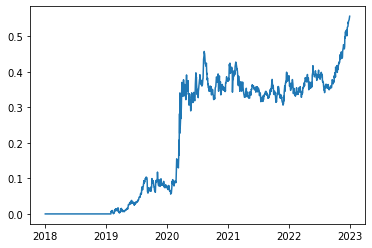

In [468]:
results_df = pd.DataFrame(x[0])
plt.plot((1 + results_df.fillna(0)).cumprod() - 1)

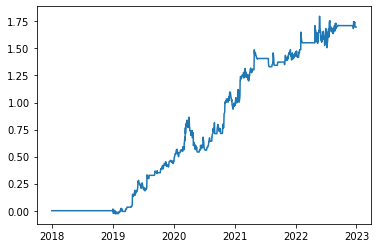

In [401]:
ts_results_df = pd.DataFrame(ts_returns)
plt.plot((1 + ts_results_df.fillna(0)).cumprod() - 1)

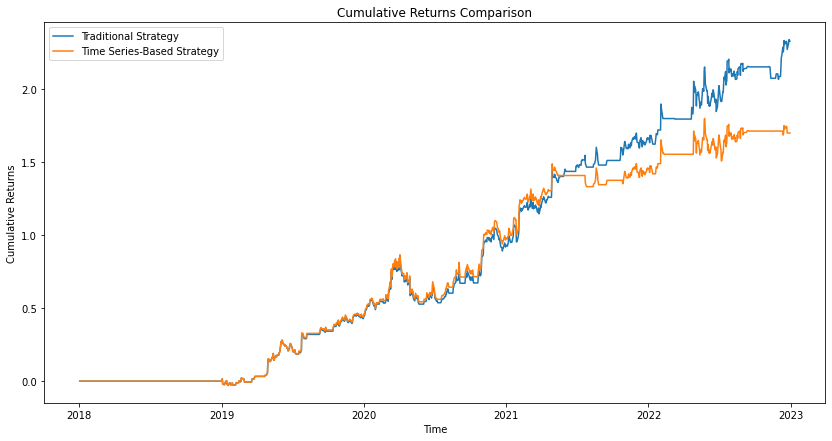

In [421]:
plt.figure(figsize=(14, 7))
plt.plot((1 + results_df.fillna(0)).cumprod() - 1, label='Traditional Strategy')
plt.plot((1 + ts_results_df.fillna(0)).cumprod() - 1, label='Time Series-Based Strategy')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [366]:
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 255 #255 trading days in a year
rf =0.01 #1% risk free rate

print(sharpe_ratio(results_df, N, rf))
print(sharpe_ratio(ts_results_df, N, rf))

0    2.264403
dtype: float64
0    3.094359
dtype: float64


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

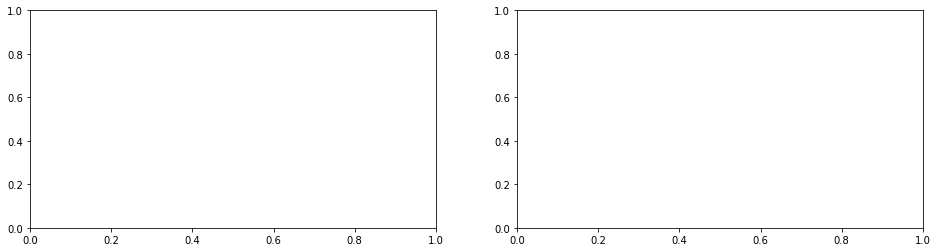

In [420]:
def plot_acf_pacf(series, lags=30):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    plt.show()

spread =  calculate_spread(data["GOOGL"], data["MSFT"])


plot_acf_pacf(spread)

In [432]:
# plt.figure(figsize=(14, 7))
# plt.plot(traditional_returns['cumulative'], label='Traditional Strategy')
# plt.plot(ts_returns['cumulative'], label='Time Series-Based Strategy')
# plt.title('Cumulative Returns Comparison')
# plt.xlabel('Time')
# plt.ylabel('Cumulative Returns')
# plt.legend()
# plt.show()


def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 255 #255 trading days in a year
rf =0.01 #1% risk free rate

print(sharpe_ratio(traditional_returns, N, rf))
print(sharpe_ratio(ts_returns, N, rf))

TypeError: cannot convert the series to <class 'float'>

KeyError: 'daily_return'

In [433]:
traditional_returns

Date
2020-12-31 00:00:00                                             0.001246
2021-01-04 00:00:00                                             -0.00133
2021-01-05 00:00:00                                              0.00147
2021-01-06 00:00:00                                             0.001908
2021-01-07 00:00:00                                             0.001675
                                             ...                        
2022-12-23 00:00:00                                            -0.002199
2022-12-27 00:00:00                                            -0.000068
2022-12-28 00:00:00                                            -0.000251
2022-12-29 00:00:00                                             0.000241
cumulative             Date
2020-12-31    0.001246
2021-01-04   -0.00...
Length: 504, dtype: object

In [437]:
# cumulative_index = traditional_returns.index[traditional_returns.index == 'cumulative'][0]

# # Slice the DataFrame to get the part above the "cumulative" entry
# traditional_returns_above_cumulative = traditional_returns[:cumulative_index]
# print(traditional_returns_above_cumulative)
# print("-----")
# print(type(traditional_returns_above_cumulative))
# print(traditional_returns_above_cumulative.mean)
# print(sharpe_ratio(traditional_returns_above_cumulative, N, rf))

Date
2020-12-31 00:00:00                                             0.001246
2021-01-04 00:00:00                                             -0.00133
2021-01-05 00:00:00                                              0.00147
2021-01-06 00:00:00                                             0.001908
2021-01-07 00:00:00                                             0.001675
                                             ...                        
2022-12-23 00:00:00                                            -0.002199
2022-12-27 00:00:00                                            -0.000068
2022-12-28 00:00:00                                            -0.000251
2022-12-29 00:00:00                                             0.000241
cumulative             Date
2020-12-31    0.001246
2021-01-04   -0.00...
Length: 504, dtype: object
-----
<class 'pandas.core.series.Series'>
<bound method NDFrame._add_numeric_operations.<locals>.mean of Date
2020-12-31 00:00:00                                    

TypeError: cannot convert the series to <class 'float'>